In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [2]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2016-01-02', 'jobs_archive_2016-01-03', 'jobs_archive_2016-01-04', 'jobs_archive_2016-01-05', 'jobs_archive_2016-01-06', 'jobs_archive_2016-01-07', 'jobs_archive_2016-01-08', 'jobs_archive_2016-01-09', 'jobs_archive_2016-01-10', 'jobs_archive_2016-01-11', 'jobs_archive_2016-01-12', 'jobs_archive_2016-01-13', 'jobs_archive_2016-01-14', 'jobs_archive_2016-01-15', 'jobs_archive_2016-01-16', 'jobs_archive_2016-01-17', 'jobs_archive_2016-01-18', 'jobs_archive_2016-01-19', 'jobs_archive_2016-01-20', 'jobs_archive_2016-01-21', 'jobs_archive_2016-01-22', 'jobs_archive_2016-01-23', 'jobs_archive_2016-01-24', 'jobs_archive_2016-01-25', 'jobs_archive_2016-01-26', 'jobs_archive_2016-01-27', 'jobs_archive_2016-01-28', 'jobs_archive_2016-01-29', 'jobs_archive_2016-01-30', 'jobs_archive_2016-01-31', 'jobs_archive_2016-02-01_reindexed', 'jobs_archive_2016-02-02_reindexed', 'jobs_archive_2016-02-03_reindexed', 'jobs_archive_2016-02-04_reindexed', 'jobs_archive_2016-02-05_reindexed', 'job

In [3]:
def time_filter(indices, last_days=60, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        if i.endswith("reindexed"):
            continue
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days <= last_days:
            filtered.append(i.rstrip())
    return filtered

In [4]:
ind = time_filter(indices, 110, "" )
ind = ','.join(ind)
print(ind)

jobs_archive_2018-01-20,jobs_archive_2018-01-21,jobs_archive_2018-01-22,jobs_archive_2018-01-23,jobs_archive_2018-01-24,jobs_archive_2018-01-25,jobs_archive_2018-01-26,jobs_archive_2018-01-27,jobs_archive_2018-01-28,jobs_archive_2018-01-29,jobs_archive_2018-01-30,jobs_archive_2018-01-31,jobs_archive_2018-02-01,jobs_archive_2018-02-02,jobs_archive_2018-02-03,jobs_archive_2018-02-04,jobs_archive_2018-02-05,jobs_archive_2018-02-06,jobs_archive_2018-02-07,jobs_archive_2018-02-08,jobs_archive_2018-02-09,jobs_archive_2018-02-10,jobs_archive_2018-02-11,jobs_archive_2018-02-12,jobs_archive_2018-02-13,jobs_archive_2018-02-14,jobs_archive_2018-02-15,jobs_archive_2018-02-16,jobs_archive_2018-02-17,jobs_archive_2018-02-18,jobs_archive_2018-02-19,jobs_archive_2018-02-20,jobs_archive_2018-02-21,jobs_archive_2018-02-22,jobs_archive_2018-02-23,jobs_archive_2018-02-24,jobs_archive_2018-02-25,jobs_archive_2018-02-26,jobs_archive_2018-02-27,jobs_archive_2018-02-28,jobs_archive_2018-03-01,jobs_archive_201

In [5]:
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:pile"
q = "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing"

In [6]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "pile",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
                     ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 10
          }
        }
      }
    }
  }
}


myqueryPile = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
          "histogram": {
                        "script": {
          "inline": "doc['IOcharReadRate'].value/1048576.",
          "lang": "expression"
        },
            "interval": 0.1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }


myqueryPile2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['IOcharRead'].value/1048576.",
          "lang": "expression"
        },
        "interval": 1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryPile3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['inputfilebytes'].value/1073741824.",
          "lang": "expression"
        },
        "interval": 0.5,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryWalltime = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 0.5,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 20
          }
        }
      }
    }
  }
}

myqueryWalltime2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 1000
          }
        }
      }
    }
  }
}

myqueryWalltime3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryWalltime4 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:reprocessing AND reqid:(15233 OR 15234 OR 15236 OR 15238) AND jobstatus:finished AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}

myqueryWalltime5 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "processingtype:reprocessing AND reqid:(14729 OR 14730 OR 14731 OR 14732) AND jobstatus:finished AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}









In [7]:
res = es.search(index=ind, body=myqueryWalltime4, request_timeout=600)

In [8]:
print(res)

{'aggregations': {'2': {'buckets': [{'key': 0.0, 'doc_count': 26}, {'key': 3.0, 'doc_count': 2}, {'key': 4.0, 'doc_count': 12}, {'key': 5.0, 'doc_count': 51}, {'key': 6.0, 'doc_count': 334}, {'key': 7.0, 'doc_count': 928}, {'key': 8.0, 'doc_count': 2193}, {'key': 9.0, 'doc_count': 3701}, {'key': 10.0, 'doc_count': 6062}, {'key': 11.0, 'doc_count': 7695}, {'key': 12.0, 'doc_count': 10295}, {'key': 13.0, 'doc_count': 14201}, {'key': 14.0, 'doc_count': 16093}, {'key': 15.0, 'doc_count': 19084}, {'key': 16.0, 'doc_count': 22359}, {'key': 17.0, 'doc_count': 24392}, {'key': 18.0, 'doc_count': 26361}, {'key': 19.0, 'doc_count': 25806}, {'key': 20.0, 'doc_count': 24914}, {'key': 21.0, 'doc_count': 25720}, {'key': 22.0, 'doc_count': 26996}, {'key': 23.0, 'doc_count': 27552}, {'key': 24.0, 'doc_count': 27086}, {'key': 25.0, 'doc_count': 25244}, {'key': 26.0, 'doc_count': 23411}, {'key': 27.0, 'doc_count': 23074}, {'key': 28.0, 'doc_count': 22435}, {'key': 29.0, 'doc_count': 21639}, {'key': 30.0,

In [9]:
xbins = []
hists = [[]]
    
# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']
    #if x>200: # This is the x-axis cut for total !
    #    continue
    xbins.append(x)
    for hist in hists:
        hist.append(r['doc_count'])
    xbin = xbin + 1

print(hists)

allsites = hists[0]
ibin = 0
sum = 0
wsum = 0
max = 0
for bin in allsites:
    if bin > max:
        max = bin
        maxbin = ibin
    sum = sum + bin
    wsum = wsum + bin * ibin
    ibin = ibin +1

mean = wsum/sum
print ("mean = %s, sum = %s, wsum = %s" %(mean, sum, wsum))
print ("max = %s, maxbin = %s " %(max, maxbin))
print("len(xbins) = %s, len(hists) = %s" %(len(xbins),len(hists)))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

colors = allcolors[:len(hists)]
#print(colors)

for hist, rel, icolor in zip(hists,rels, colors):
    sum = 0
    for i in hist:
        sum = sum + i
    print (rel, sum )
    
for hist, rel, icolor in zip(hists, rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=y_offset, log=False, label=rel, color=icolor, width=1)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    y_offset = y_offset + hist
    #print(hist)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per event times Ncores [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,200])
plt.text(100, 10000, r'2nd half, RAW input only')
plt.text(100, 8000, r'%s finished jobs' %sum)
plt.text(100, 6000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.savefig("walltimes_2nd_test.png")
plt.show()



[[26, 2, 12, 51, 334, 928, 2193, 3701, 6062, 7695, 10295, 14201, 16093, 19084, 22359, 24392, 26361, 25806, 24914, 25720, 26996, 27552, 27086, 25244, 23411, 23074, 22435, 21639, 21686, 20937, 20564, 19170, 18550, 17417, 17216, 17026, 16570, 15452, 15145, 14620, 14015, 13380, 12863, 12328, 11401, 10364, 9519, 8538, 7806, 7151, 6677, 6312, 5824, 5360, 5072, 4748, 4379, 4088, 3786, 3418, 3139, 2820, 2556, 2341, 2200, 1912, 1677, 1552, 1482, 1236, 1069, 963, 963, 902, 770, 701, 690, 643, 633, 566, 482, 515, 431, 436, 420, 406, 378, 351, 305, 297, 303, 280, 244, 257, 256, 235, 254, 275, 239, 259, 250, 273, 333, 327, 294, 310, 323, 336, 272, 243, 265, 238, 207, 197, 164, 155, 135, 119, 114, 88, 79, 78, 87, 72, 67, 56, 80, 66, 65, 44, 50, 44, 49, 57, 40, 43, 40, 48, 62, 41, 46, 34, 43, 54, 29, 39, 40, 45, 39, 35, 31, 25, 26, 21, 32, 29, 29, 34, 14, 24, 24, 16, 21, 14, 18, 18, 23, 20, 20, 13, 24, 14, 20, 21, 21, 13, 12, 19, 13, 18, 14, 12, 16, 10, 12, 12, 18, 16, 12, 19, 9, 8, 10, 9, 4, 11, 13,

NameError: name 'rels' is not defined

In [122]:
res2= es.search(index=ind, body=myqueryWalltime5, request_timeout=600)

[[24, 11, 488, 850, 1442, 3565, 5555, 9312, 14244, 17790, 21280, 25086, 26885, 28202, 28927, 29554, 30362, 29182, 27589, 25809, 23522, 21012, 19250, 17193, 15272, 13434, 11819, 10211, 8825, 7458, 6658, 5733, 4964, 4342, 3883, 3430, 2851, 2517, 2216, 1915, 1595, 1464, 1313, 1221, 1038, 933, 933, 834, 768, 756, 617, 623, 604, 523, 509, 530, 443, 410, 383, 335, 345, 306, 289, 266, 272, 248, 195, 208, 186, 193, 191, 192, 143, 163, 153, 137, 135, 122, 120, 116, 112, 106, 99, 88, 85, 82, 87, 89, 80, 68, 86, 68, 74, 51, 44, 56, 81, 47, 56, 39, 56, 48, 44, 42, 34, 32, 36, 37, 35, 27, 27, 35, 26, 27, 24, 25, 21, 28, 24, 22, 23, 19, 14, 23, 18, 14, 13, 27, 17, 19, 17, 13, 19, 10, 11, 14, 12, 17, 5, 19, 19, 16, 18, 11, 13, 15, 15, 13, 8, 14, 13, 13, 15, 13, 16, 7, 15, 15, 11, 11, 14, 8, 12, 9, 9, 9, 11, 8, 6, 11, 11, 13, 4, 6, 10, 8, 12, 6, 4, 11, 7, 8, 10, 11, 8, 8, 8, 9, 10, 11, 7, 9, 8, 4, 12, 7, 6, 5, 9, 2, 2, 6, 8, 4, 7, 6, 5, 8, 8, 9, 7, 6, 6, 6, 8, 6, 4, 6, 8, 5, 6, 7, 8, 4, 1, 6, 5, 9, 3,

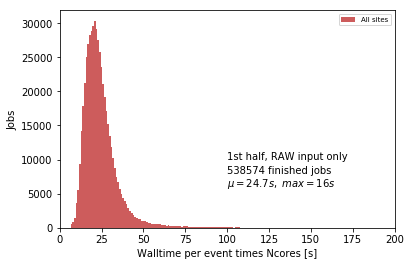

In [126]:
xbins2 = []
hists2 = [[]]
    
# Now loop again and fill the histogram bins            
xbin = 0
for r in res2['aggregations']['2']['buckets']:
    x = r['key']
    #if x>200: # This is the x-axis cut for total !
    #    continue
    xbins2.append(x)
    for hist in hists2:
        hist.append(r['doc_count'])
    xbin = xbin + 1

print(hists2)

allsites = hists2[0]
ibin = 0
sum2 = 0
wsum2 = 0
max2 = 0
for bin in allsites:
    if bin > max2:
        max2 = bin
        maxbin2 = ibin
    sum2 = sum2 + bin
    wsum2 = wsum2 + bin * ibin
    ibin = ibin +1

mean2 = wsum2/sum2
print ("mean = %s, sum = %s, wsum = %s" %(mean2, sum2, wsum2))
print ("max = %s, maxbin = %s " %(max2, maxbin2))
print("len(xbins) = %s, len(hists) = %s" %(len(xbins2),len(hists2)))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins2))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

colors = allcolors[:len(hists)]
#print(colors)

for hist, rel, icolor in zip(hists2,rels, colors):
    sum2 = 0
    for i in hist:
        sum2 = sum2 + i
    print (rel, sum2 )
    
for hist, rel, icolor in zip(hists2, rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins2, hist, bottom=y_offset, log=False, label=rel, color=icolor, width=1)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    y_offset = y_offset + hist
    #print(hist)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per event times Ncores [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,200])
plt.text(100, 10000, r'1st half, RAW input only')
plt.text(100, 8000, r'%s finished jobs' %sum2)
plt.text(100, 6000, r'$\mu=%2.1f s,\ max=%s s$'%(mean2, maxbin2))

plt.savefig("walltimes_1st.png")
plt.show()




1519 2015 1519 2015


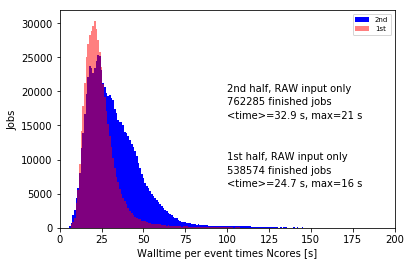

In [127]:
print (len(hists[0]), len(hists2[0]), len(xbins), len(xbins2))

allhists = [hists, hists2]
periods = ["2nd","1st"]

plt.bar(xbins, hists[0], log=False, label=periods[0], color="b", width=1, lw=1)
plt.bar(xbins2, hists2[0], log=False, label=periods[1], color="r", width=1, alpha =0.5, lw=1)

plt.xlabel('Walltime per event times Ncores [s]')
plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,200])
#plt.text(60, 6000, r'1st/2nd half, RAW input, finished jobs')
#plt.text(100, 8000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.text(100, 20000, r'2nd half, RAW input only')
plt.text(100, 18000, r'%s finished jobs' %sum)
plt.text(100, 16000, r'<time>=%2.1f s, max=%s s'%(mean, maxbin))

plt.text(100, 10000, r'1st half, RAW input only')
plt.text(100, 8000, r'%s finished jobs' %sum2)
plt.text(100, 6000, r'<time>=%2.1f s, max=%s s'%(mean2, maxbin2))





plt.savefig("walltimes_both.png")
plt.show()

